In [1]:
!hostname

interactive2


In [3]:
%run ../scripts/greedy_partitioner.py

IOError: file `` not found

In [6]:
siteslist = []
pbar = ProgressBar(61100)
for line in open("/hpc/users/neffr01/jason_new/hapcut_outputs/truth_test_methyl_sig_sites.tsv", 'r'):
    pbar.animate()
    chrom, pos, mean1, mean2 = line.strip('\n').split(' ')
    pos, mean1, mean2 = int(pos), float(mean1), float(mean2)
    siteslist.append([chrom, pos, mean1, mean2])

In [8]:
siteslist[-1]

['000000F', 30161039, 2.69464089244, 3.48228381491]

In [4]:
%run ipy_setup.py
%matplotlib inline
from sklearn import mixture
import sklearn
import pysam
import math
from IPython import display
from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric.kernel_density import KDEMultivariate
from scipy import stats
import itertools
import matplotlib.gridspec as gridspec

def kde_scipy(x, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scipy"""
    # Note that scipy weights its bandwidth by the covariance of the
    # input data.  To make the results comparable to the other methods,
    # we divide the bandwidth by the sample standard deviation here.
    kde = gaussian_kde(x, bw_method=bandwidth / x.std(ddof=1), **kwargs)
    return kde.evaluate(x_grid)

pd.set_option('display.width', 900)
pd.set_option('display.max_columns', 100)
plt.style.use('ggplot')
rcParams['figure.figsize'] = (12, 8)
rcParams['figure.dpi'] = 150
rcParams['font.size'] = 16
rcParams['font.family'] = 'Bitstream Vera Sans'

read_bpos = dict()

def get_refmap(bamread):
    bpos = bamread.get_aligned_pairs(matches_only=True)
    positions = [i[0] for i in bpos]
    refpos =  [i[1] for i in bpos] # positions in reference
    refmap = dict(zip(refpos, positions))
    return refmap

def get_matched_bases_in_read(bamread, in_pos, refmap, read_bpos=read_bpos):
    outseq = [bamread.seq[refmap[i]] if i in refmap else 'N' for i in in_pos]
    outseq = ''.join(outseq)
    return outseq

def get_position_in_read(bamread, in_pos, refmap, read_bpos=read_bpos):
    outpos = None
    if in_pos in refmap:
        outpos = refmap[in_pos]
    return outpos

def reverse_compl(seq):
    translate = {'A':'T', 
                 'T':'A', 
                 'C':'G',
                 'G':'C', 
                 'N':'N'}
    return ''.join([translate[s] for s in seq])

In [5]:
motifs_in = open('/hpc/users/neffr01/jason_new/hapcut_outputs/hg002_re_000000F/ipds/hg002_ipds_priors_merged_000000F.sort.dedup.tsv', 'rb')
motif_dict = dict()
pbar = ProgressBar(3201285)
for line in motifs_in:
    pbar.animate()
    motif,data = line.strip('\n').split('\t')
    motif_dict[motif] = data

[*****************99%******************]  3170900 of 3201285 complete Elapsed: 1.7 minutes	 Remaining: 0.0 minutes


In [ ]:
'''
make a plot of sig sites across a block
'''

In [14]:
siteslist = []
pbar = ProgressBar(61100)
for line in open("/hpc/users/neffr01/jason_new/hapcut_outputs/hg002_qv13_methyl_sig_sites-novariant-11mer.tsv", 'r'):
    pbar.animate()
    chrom, pos, mean1, mean2 = line.strip('\n').split(' ')
    pos, mean1, mean2 = int(pos), float(mean1), float(mean2)
    siteslist.append([chrom, pos, mean1, mean2])
    
bam_fp = pysam.AlignmentFile("/hpc/users/neffr01/jason_new/hapcut_outputs/hg002_re_000000F/hg002.000000F.het_sites_truth_partition_snps_only.bam", "rb")
#out_fp = pysam.AlignmentFile("~/jason_new/hapcut_outputs/hg002_re_000000F/hg002_methyl_phased-from-trio-data_000000F.bam", 'wb')
out_predict = open("/hpc/users/neffr01/jason_new/methyl_predict/hg002_methyl_denovo_vs_truth.tsv", "w")
predictions = []
pbar = ProgressBar(170000)

for read in bam_fp.fetch():
    pbar.animate()
    rstart, rend = read.pos, read.aend
    sigoverlap = [i for i in siteslist if (i[1] <= rend) & (i[1] >= rstart)]
    if len(sigoverlap) == 0:
        continue
    refmap = get_refmap(read)
    ipd_values = [int(i) for i in read.get_tag('ip').strip('S').split(',')]
    #hap = int(read.get_tag('ZH').split(";")[0].split(",")[1])
    hap = read.get_tag('ZH')
    pv = read.get_tag('ZV')
    res = []
    for row in sigoverlap:
        refpos = row[1]
        basepos = get_position_in_read(read, refpos, refmap)
        if basepos==None: continue
        ipd_value = np.log(ipd_values[basepos])
        #motif = refseq[refpos-5-(rstart):refpos+6-rstart]
        #ref_3mer = motif[4:7]
        #read_3mer = get_matched_bases_in_read(read, range(refpos-1,refpos+2), refmap)
        #if ref_3mer != read_3mer: continue
        res.append([abs(row[2]-ipd_value), abs(row[3]-ipd_value)])
    if res != []:
        #print read.qname
        hap1_res = sum([i[0] for i in res])
        hap2_res = sum([i[1] for i in res])
        predict_hap = None
        if hap1_res > hap2_res:
            predict_hap = 2
        else:
            predict_hap = 1
        #print "Predicted:\t", predict_hap, "actual:\t", hap
        predictions.append([predict_hap, hap, len(res), pv, hap1_res, hap2_res, read.alen])
        print >>out_predict, predict_hap, hap, len(res), pv, hap1_res, hap2_res, read.alen
        out_predict.flush()

[                  1%                  ]  1585 of 170000 complete Elapsed: 3.0 minutes	 Remaining: 316.0 minutes

KeyboardInterrupt: 

partition variants >= 0 prediction acc: 0.645 n= 445
partition variants >= 1 prediction acc: 0.702 n= 205
partition variants >= 2 prediction acc: 0.729 n= 133
partition variants >= 3 prediction acc: 0.863 n= 51
partition variants >= 4 prediction acc: 1.0 n= 23
partition variants >= 5 prediction acc: 1.0 n= 14
partition variants >= 6 prediction acc: 1.0 n= 8


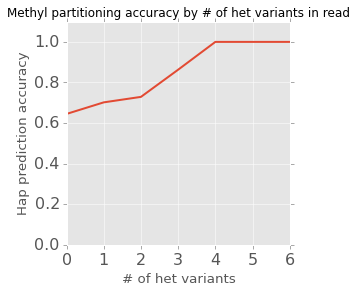

In [247]:
rcParams['figure.figsize'] = (4, 4)
rcParams['axes.titlesize'] = 12
pltarr = []
for var in range(0,10):
    predcheck = [i for i in predictions if i[3] > var]
    if len(predcheck) == 0:
        break
    acc = round(np.mean([1 if i[0] == i[1] else 0 for i in predcheck]), 3)
    n = len(predcheck)
    pltarr.append([var, acc, n])
    print "partition variants >=", var, "prediction acc:", acc , "n=", n
plt.title("Methyl partitioning accuracy by # of het variants in read")
plt.plot([i[0] for i in pltarr], [i[1] for i in pltarr])
plt.ylim([0,1.1])
plt.xlabel("# of het variants", fontsize='small')
plt.ylabel("Hap prediction accuracy", fontsize='small')
plt.show()

partition variants >= 0 prediction acc: 0.645 n= 445
partition variants >= 1000 prediction acc: 0.645 n= 439
partition variants >= 2000 prediction acc: 0.639 n= 413
partition variants >= 3000 prediction acc: 0.629 n= 388
partition variants >= 4000 prediction acc: 0.615 n= 358
partition variants >= 5000 prediction acc: 0.605 n= 332
partition variants >= 6000 prediction acc: 0.601 n= 303
partition variants >= 7000 prediction acc: 0.611 n= 270
partition variants >= 8000 prediction acc: 0.618 n= 241
partition variants >= 9000 prediction acc: 0.614 n= 215
partition variants >= 10000 prediction acc: 0.608 n= 189
partition variants >= 11000 prediction acc: 0.618 n= 152
partition variants >= 12000 prediction acc: 0.589 n= 112
partition variants >= 13000 prediction acc: 0.59 n= 83
partition variants >= 14000 prediction acc: 0.689 n= 61
partition variants >= 15000 prediction acc: 0.61 n= 41
partition variants >= 16000 prediction acc: 0.652 n= 23
partition variants >= 17000 prediction acc: 0.667 

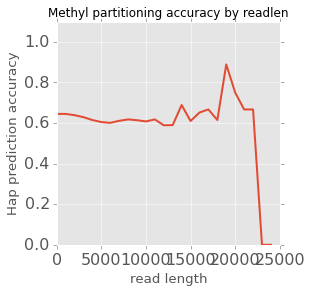

In [248]:
rcParams['figure.figsize'] = (4, 4)
rcParams['axes.titlesize'] = 12
pltarr = []
for var in range(0,25000,1000):
    predcheck = [i for i in predictions if i[6] > var]
    if len(predcheck) == 0:
        break
    acc = round(np.mean([1 if i[0] == i[1] else 0 for i in predcheck]), 3)
    n = len(predcheck)
    pltarr.append([var, acc, n])
    print "partition variants >=", var, "prediction acc:", acc , "n=", n
plt.title("Methyl partitioning accuracy by readlen")
plt.plot([i[0] for i in pltarr], [i[1] for i in pltarr])
plt.ylim([0,1.1])
plt.xlabel("read length", fontsize='small')
plt.ylabel("Hap prediction accuracy", fontsize='small')
plt.show()